In [1]:
#1.imports and dataloading
import pandas as pd
import matplotlib.pyplot as plt


In [2]:

sentiment = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")


In [3]:
#2.Dataset Documentation
summary = pd.DataFrame({
    "rows": [sentiment.shape[0], trades.shape[0]],
    "columns": [sentiment.shape[1], trades.shape[1]],
    "missing_pct": [
        sentiment.isna().mean().mean(),
        trades.isna().mean().mean()
    ],
    "duplicates": [
        sentiment.duplicated().sum(),
        trades.duplicated().sum()
    ]
}, index=["sentiment", "trades"])

summary


,rows,columns,missing_pct,duplicates
sentiment,2644,4,0.0,0
trades,211224,16,0.0,0


In [4]:
sentiment.info()
trades.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-nu

In [5]:
#Cleaning and date alignment
sentiment.columns = sentiment.columns.str.lower().str.replace(" ", "_")
trades.columns = trades.columns.str.lower().str.replace(" ", "_")


In [6]:
trades['timestamp'] = pd.to_datetime(trades['timestamp'], unit='ms')
trades['date'] = trades['timestamp'].dt.date

sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date


In [7]:
#4. Feature Engineering (Daily Trader Metrics)
daily = trades.groupby(['date', 'account']).agg(
    daily_pnl=('closed_pnl', 'sum'),
    trades_count=('trade_id', 'count'),
    avg_trade_size=('size_usd', 'mean'),
    win_rate=('closed_pnl', lambda x: (x > 0).mean()),
    long_ratio=('side', lambda x: (x.str.lower() == 'buy').mean()),
    total_fees=('fee', 'sum')
).reset_index()


In [8]:
#5. Merge Market Sentiment
daily = daily.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='inner'
)


In [9]:
daily['classification'].value_counts()


classification
Greed            32
Fear             32
Neutral           8
Extreme Greed     5
Name: count, dtype: int64

In [10]:
# 6. Performance vs Sentiment
daily.groupby('classification')[['daily_pnl', 'win_rate']].mean()


,daily_pnl,win_rate
classification,,
Extreme Greed,35393.098355,0.336609
Fear,209372.662205,0.415878
Greed,99675.516731,0.374074
Neutral,19842.797260,0.260683


In [11]:
import os
os.makedirs("outputs", exist_ok=True)
os.makedirs("csv_files", exist_ok=True)


In [12]:
daily.boxplot(column='daily_pnl', by='classification', grid=False)
plt.title("Daily PnL Distribution by Market Sentiment")
plt.suptitle("")
plt.savefig("outputs/pnl_by_sentiment.png")
plt.close()


In [13]:
#7. Behavior Change Analysis
daily.groupby('classification')[[
    'trades_count',
    'avg_trade_size',
    'long_ratio',
    'total_fees'
]].mean()


,trades_count,avg_trade_size,long_ratio,total_fees
classification,,,,
Extreme Greed,1392.40000,4344.447836,0.518479,1362.556247
Fear,4183.46875,5926.522723,0.459352,4531.813863
Greed,1134.03125,5839.310974,0.495780,760.438543
Neutral,892.62500,3793.444161,0.468967,1092.984686


In [14]:
# 8. Trader Segmentation (REQUIRED)
#Segment 1: Activity
daily['activity_bucket'] = pd.qcut(
    daily['trades_count'], 2,
    labels=['Low activity', 'High activity']
)


In [15]:
daily.groupby(['classification', 'activity_bucket'])['daily_pnl'].mean()


C:\Users\Sangeetha\AppData\Local\Temp\ipykernel_24284\930475966.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily.groupby(['classification', 'activity_bucket'])['daily_pnl'].mean()


classification  activity_bucket
Extreme Greed   Low activity        -4494.495724
                High activity       95224.489473
Fear            Low activity        42168.941645
                High activity      265107.235726
Greed           Low activity        28452.671557
                High activity      281689.454396
Neutral         Low activity        26254.572028
                High activity        9156.505979
Name: daily_pnl, dtype: float64

In [16]:
#Segment 2: Risk (Trade Size Proxy)

daily['risk_bucket'] = pd.qcut(
    daily['avg_trade_size'], 2,
    labels=['Lower risk', 'Higher risk']
)


In [17]:
daily.groupby(['classification', 'risk_bucket'])['daily_pnl'].mean()


C:\Users\Sangeetha\AppData\Local\Temp\ipykernel_24284\1338765772.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily.groupby(['classification', 'risk_bucket'])['daily_pnl'].mean()


classification  risk_bucket
Extreme Greed   Lower risk          0.000000
                Higher risk     44241.372943
Fear            Lower risk     112831.554518
                Higher risk    284460.190407
Greed           Lower risk     143718.073412
                Higher risk     35305.626196
Neutral         Lower risk      39848.078033
                Higher risk    -13499.337363
Name: daily_pnl, dtype: float64

In [18]:
#Segment 3: Consistency
pnl_vol = daily.groupby('account')['daily_pnl'].std().reset_index()
pnl_vol.columns = ['account', 'pnl_volatility']

daily = daily.merge(pnl_vol, on='account', how='left')


In [19]:
daily['consistency'] = pd.qcut(
    daily['pnl_volatility'], 2,
    labels=['Consistent', 'Volatile']
)


In [20]:
daily.groupby(['classification', 'consistency'])['daily_pnl'].mean()


C:\Users\Sangeetha\AppData\Local\Temp\ipykernel_24284\1852878539.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily.groupby(['classification', 'consistency'])['daily_pnl'].mean()


classification  consistency
Extreme Greed   Consistent      -5564.016140
                Volatile        45632.376978
Fear            Consistent      31376.268105
                Volatile       375132.429461
Greed           Consistent      30104.373752
                Volatile       178522.812106
Neutral         Consistent      -5853.977069
                Volatile        45539.571589
Name: daily_pnl, dtype: float64

In [21]:
# 9. Save Outputs 
daily.to_csv("csv_files/daily_trader_metrics.csv", index=False)


In [22]:
# ================================
# OUTPUTS: SAVE CHARTS & TABLES
# ================================


In [23]:
import os
os.makedirs("outputs", exist_ok=True)
os.makedirs("csv_files", exist_ok=True)


In [24]:
# Chart 1: PnL by sentiment
daily.boxplot(column='daily_pnl', by='classification', grid=False)
plt.title("Daily PnL Distribution by Market Sentiment")
plt.suptitle("")
plt.savefig("outputs/pnl_by_sentiment.png")
plt.close()


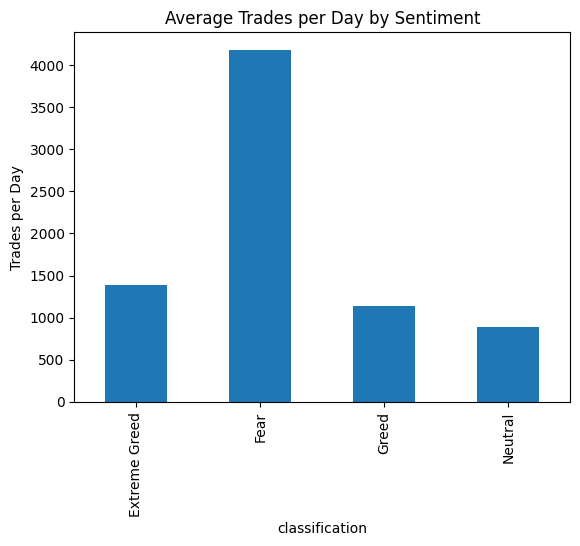

In [28]:
# Chart 2: Trade frequency by sentiment
daily.groupby('classification')['trades_count'].mean().plot(kind='bar')
plt.title("Average Trades per Day by Sentiment")
plt.ylabel("Trades per Day")
plt.savefig("outputs/trade_frequency_by_sentiment.png")
plt.show()
plt.close()


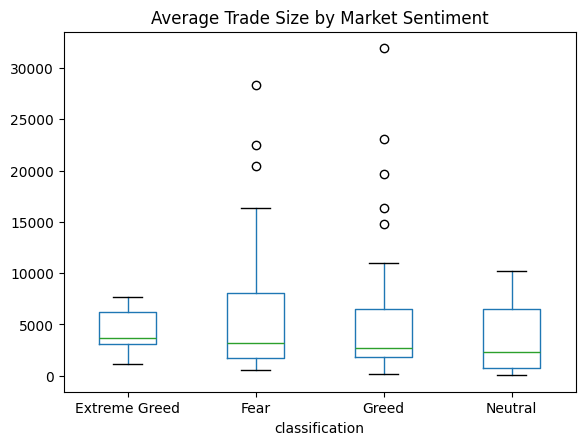

In [29]:
# Chart 3: Trade size by sentiment
daily.boxplot(column='avg_trade_size', by='classification', grid=False)
plt.title("Average Trade Size by Market Sentiment")
plt.suptitle("")
plt.savefig("outputs/trade_size_by_sentiment.png")
plt.show()
plt.close()



In [33]:
summary_table = daily.groupby('classification')[[
    'daily_pnl',
    'win_rate',
    'trades_count',
    'avg_trade_size'
]].mean()
display(summary_table)

summary_table.to_csv("outputs/summary_metrics_by_sentiment.csv")



,daily_pnl,win_rate,trades_count,avg_trade_size
classification,,,,
Extreme Greed,35393.098355,0.336609,1392.40000,4344.447836
Fear,209372.662205,0.415878,4183.46875,5926.522723
Greed,99675.516731,0.374074,1134.03125,5839.310974
Neutral,19842.797260,0.260683,892.62500,3793.444161
